# K-Means: Visualización paso a paso

En este cuaderno, vamos a explicar de forma práctica el algoritmo **K-Means** y ver cómo evolucionan los centroides y las asignaciones de los puntos en cada iteración, con un retardo de 3 segundos entre cada paso.

## 1. Introducción

El algoritmo **K-Means** es uno de los métodos de _clustering_ (agrupación no supervisada) más populares. Su objetivo es agrupar un conjunto de puntos o instancias en K grupos diferentes, de forma que los puntos dentro de un mismo grupo sean lo más similares entre sí y lo más diferentes posible de los puntos de otros grupos.

### ¿En qué consiste K-Means?
1. Se elige un número de clusters (K).
2. Se inicializan K centroides (de forma aleatoria o mediante algún método como k-means++).
3. De manera iterativa, se asignan los puntos al centroide más cercano y se recalculan las posiciones de los centroides como el promedio de los puntos asignados a cada uno.
4. Se repite el proceso hasta que los centroides no cambien o se alcance un número máximo de iteraciones.

### Aplicaciones Comunes
- Segmentación de clientes en marketing.
- Agrupación de imágenes o compresión de datos.
- Búsqueda de patrones en grandes volúmenes de datos.

### Conceptos básicos
- **Centroides**: puntos que representan cada cluster.
- **Clusters**: subgrupos o conjuntos de puntos que comparten cierta cercanía entre sí.
- **Función de costo**: normalmente, la suma de las distancias (al cuadrado) de cada punto a su centroide.

### Proceso iterativo
1. **Asignación**: cada punto se asigna al centroide más cercano.
2. **Actualización de centroides**: se recalculan los centroides como la media de los puntos asignados a cada cluster.
3. Se repite hasta convergencia.

En las siguientes secciones crearemos un dataset artificial, aplicaremos el algoritmo con **scikit-learn** y mostraremos paso a paso el proceso de convergencia de los centroides.

## 2. Generación del Dataset Artificial

Utilizaremos la función `make_blobs()` de `sklearn.datasets` para crear un conjunto de puntos con características fácilmente separables (o casi). Luego mostraremos gráficamente la distribución inicial de los datos.

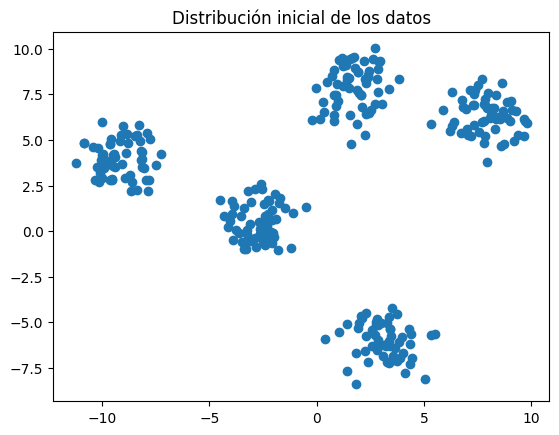

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Generamos un dataset con 300 puntos y 3 centros.
X, _ = make_blobs(n_samples=300, centers=5, n_features=2, random_state=20)

# Visualizamos la distribución inicial
plt.figure()
plt.title("Distribución inicial de los datos")
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## 3. Aplicación del Algoritmo K-means

En esta sección, mostraremos cómo usar **KMeans** de `sklearn.cluster` para, finalmente, obtener la agrupación final. Sin embargo, para **visualizar paso a paso** cada iteración, implementaremos un proceso manual muy parecido al que realiza el modelo de scikit-learn internamente:

1. Inicializar centroides aleatoriamente.
2. Asignar cada punto al centroide más cercano.
3. Recalcular los centroides.
4. Repetir hasta que no haya cambios o se alcance el número máximo de iteraciones.

Después de mostrar la animación, usaremos la clase `KMeans` para mostrar cómo quedaría el resultado final oficial según scikit-learn.

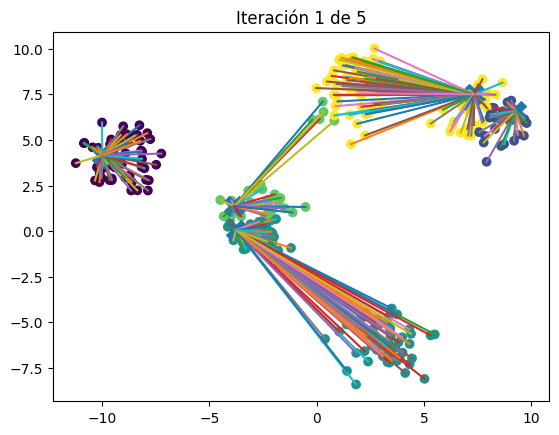

In [24]:
# --- Funciones auxiliares para el paso a paso de K-Means manual --- #

def initialize_centroids(X, k):
    """
    Elige k puntos aleatoriamente del dataset X como centroides iniciales.
    """
    np.random.seed(10)
    indices = np.random.choice(len(X), size=k, replace=False)
    return X[indices, :]

def assign_clusters(X, centroids):
    """
    Asigna cada punto al centroide más cercano.
    Devuelve un array con los índices de los centroides asignados.
    """
    distances = np.zeros((len(X), len(centroids)))
    for i, c in enumerate(centroids):
        # Calculamos la distancia euclídea de cada punto al centroide c
        distances[:, i] = np.sqrt(((X - c) ** 2).sum(axis=1))
    # Etiqueta de cluster = índice del centroide más cercano
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """
    Calcula el nuevo centroide como la media de todos los puntos asignados a cada cluster.
    """
    new_centroids = np.zeros((k, X.shape[1]))
    for cluster_id in range(k):
        points = X[labels == cluster_id]
        if len(points) > 0:
            new_centroids[cluster_id] = points.mean(axis=0)
    return new_centroids

def kmeans_step_by_step(X, k=3, max_iters=10):
    """
    Implementa K-Means de forma manual y 
    guarda el estado de cada iteración para la animación.
    """
    # Inicializar centroides de forma aleatoria
    centroids = initialize_centroids(X, k)
    states = []  # guardaremos (centroids, labels) de cada iteración

    for _ in range(max_iters):
        # Asignar cada punto al centroide más cercano
        labels = assign_clusters(X, centroids)

        # Guardamos el estado para visualizarlo
        states.append((centroids.copy(), labels.copy()))

        # Recalcular centroides
        new_centroids = update_centroids(X, labels, k)

        # Si no hay cambios, terminamos
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    # Añadimos el estado final
    final_labels = assign_clusters(X, centroids)
    states.append((centroids.copy(), final_labels.copy()))

    return states

# Generamos los estados de K-Means paso a paso
k = 5  # número de clusters
states = kmeans_step_by_step(X, k=k, max_iters=15)

# Ahora creamos la animación
fig = plt.figure()
plt.title("Evolución de K-Means Iteración a Iteración")

def update(frame_index):
    # Limpieza de la figura
    plt.clf()

    centroids, labels = states[frame_index]

    # Puntos, coloreados según su cluster
    plt.scatter(X[:, 0], X[:, 1], c=labels)

    # Dibujamos las líneas desde cada punto a su centroide
    for i, c_id in enumerate(labels):
        cx, cy = centroids[c_id]
        plt.plot([X[i, 0], cx], [X[i, 1], cy])

    # Dibujamos los centroides como X grandes
    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        marker='X', s=200
    )

    plt.title(f"Iteración {frame_index+1} de {len(states)}")

# Creamos la animación usando FuncAnimation
anim = FuncAnimation(fig, update, frames=len(states), interval=3000, repeat=False)

# Mostramos la animación en Jupyter
HTML(anim.to_jshtml())

## 4. Resultado Final con Scikit-Learn

Aunque acabamos de simular paso a paso cómo funciona K-Means, normalmente solo necesitamos hacer lo siguiente con la librería scikit-learn:

1. Crear la instancia de `KMeans` con el número de clusters.
2. Ajustar el modelo con los datos.
3. Obtener etiquetas y centroides.
4. Visualizar el resultado final.

Aquí lo hacemos de forma sencilla.

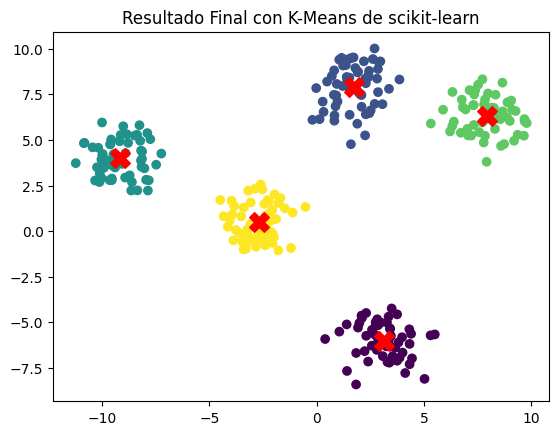

In [30]:
# Usamos KMeans de scikit-learn para un resultado "oficial"
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Asigna cada punto del conjunto de datos 'X' al cluster más cercano, utilizando los centroides calculados previamente.
# Esperamos un array de etiquetas que indica a qué cluster pertenece cada punto.
# Ejemplo: [0, 1, 0, 2, 1, 0, ...] si tenemos tres clusters (0, 1, 2).
labels_sk = kmeans.predict(X)
# Recuperar las coordenadas de los centroides finales
# Por ejemplo, si tenemos 3 clusters y estamos trabajando en 2D, será un array de tamaño [3, 2].
# Ejemplo: [[1.5, 2.0], [-1.0, -2.0], [3.0, -0.5]]
centers_sk = kmeans.cluster_centers_

plt.figure()
plt.title("Resultado Final con K-Means de scikit-learn")
# Dibuja los puntos del dataset, coloreados según el cluster al que pertenecen.
plt.scatter(X[:, 0], X[:, 1], c=labels_sk)

# Dibuja los centroides encontrados con un marcador 'X' grande.
plt.scatter(
    centers_sk[:, 0], centers_sk[:, 1],  # Coordenadas X e Y de cada centroide
    marker='X',                          # Marcador de tipo 'X'
    s=200,                               # Tamaño del marcador
    color='red'                          # Color del marcador negro
)
plt.show()

## 5. Conclusiones

En este cuaderno hemos visto cómo funciona el algoritmo **K-Means**:

- El algoritmo alterna entre asignar cada punto al centroide más cercano y recalcular las posiciones de los centroides.
- Hemos apreciado paso a paso cómo los centroides se van moviendo hasta converger.
- También hemos usado la clase `KMeans` de **scikit-learn**, que implementa el mismo método de forma más optimizada.

### Aplicaciones y Limitaciones
- **Aplicaciones**: Segmentación de clientes, agrupación de documentos, compresión de imágenes, etc.
- **Limitaciones**: Requiere especificar K, puede converger a mínimos locales, no es bueno con clusters de forma arbitraria y puede verse afectado por outliers.

